In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import os

def preprocess_image(image, label, image_shape=224):
  image= tf.image.resize(image,[image_shape, image_shape])
  return tf.cast(image, tf.float32), label

In [2]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split = ["train", "validation"],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='C:\\Users\\Essam\\tensorflow_datasets\\food101\\2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train'

In [4]:
print(f"Training dataset size: {tf.data.experimental.cardinality(train_data).numpy()}")
print(f"Test dataset size: {tf.data.experimental.cardinality(test_data).numpy()}")

Training dataset size: 75750
Test dataset size: 25250


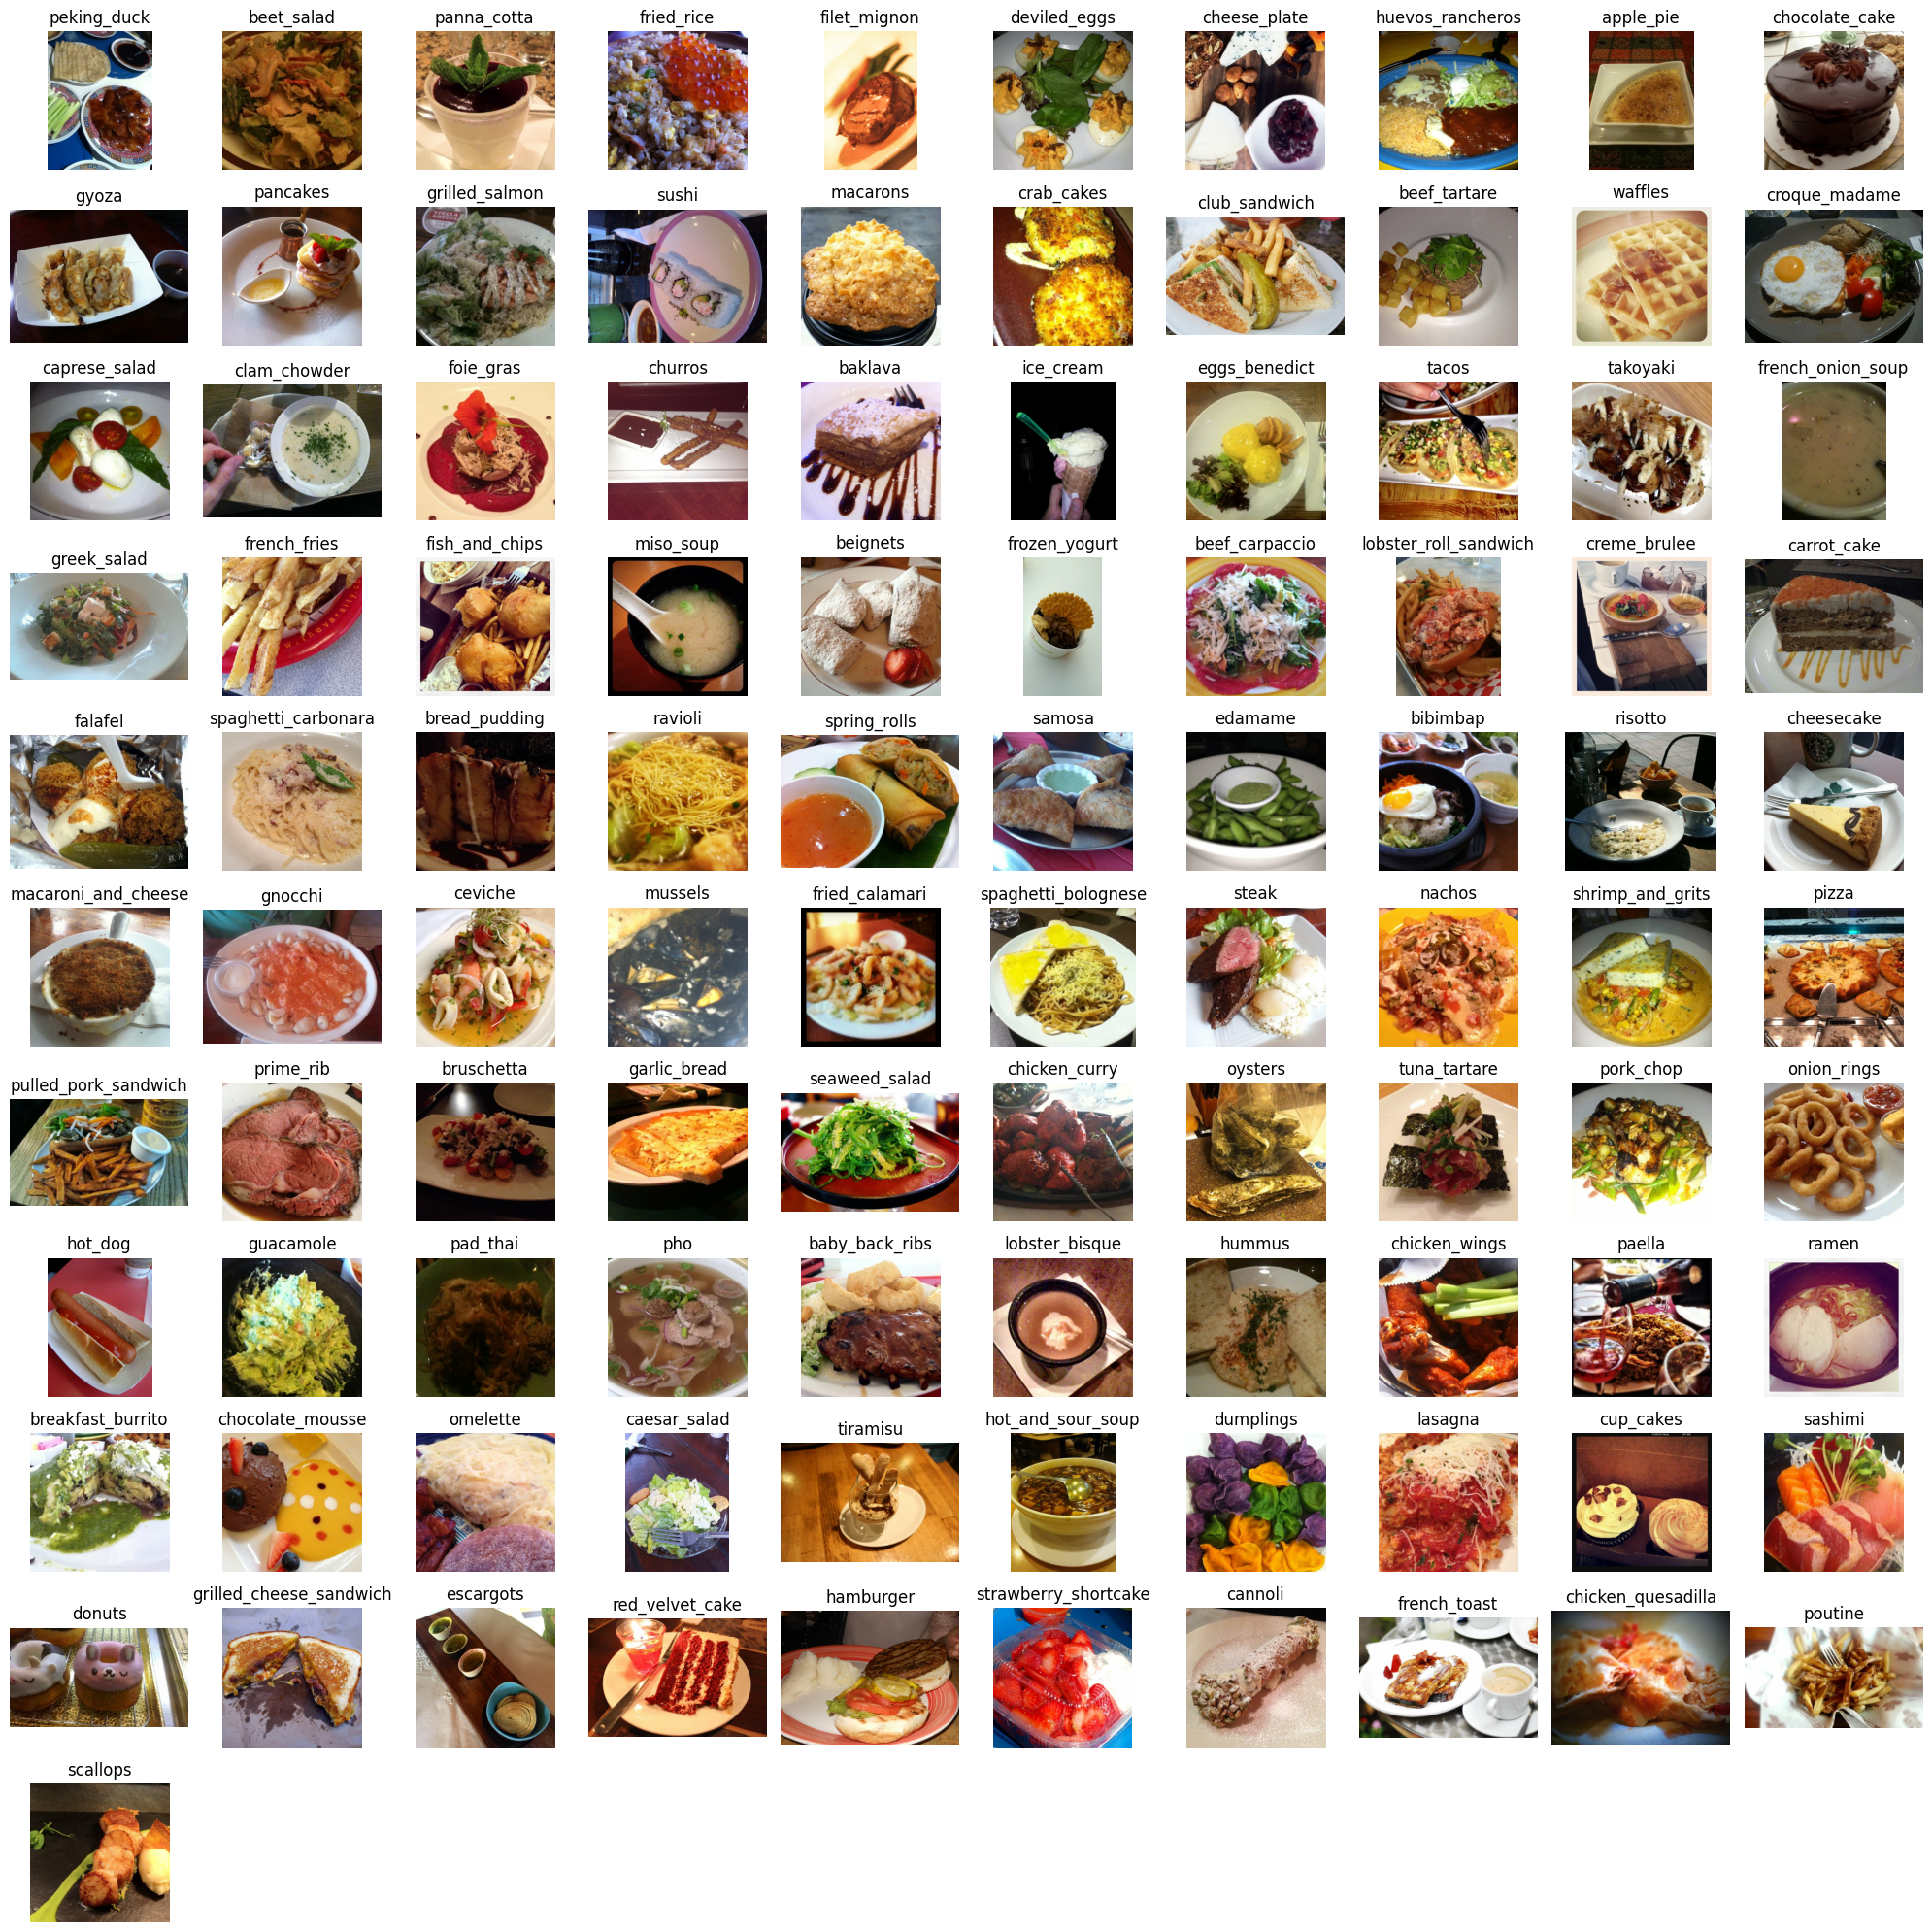

In [5]:
class_names = ds_info.features["label"].names
class_images = {}

for image, label in train_data:
    label_int = label.numpy()

    if label_int not in class_images:
        class_images[label_int] = image

    if len(class_images) == len(class_names):
        break

plt.figure(figsize=(20, 20))
for idx, (class_label, image) in enumerate(class_images.items()):
    plt.subplot(11, 10, idx + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[class_label])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
train_data = train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
checkpoint_dir = "model_checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, "cp.weights2.h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=2,
                                                  restore_best_weights=True)

In [8]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
mixed_precision.global_policy()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


<Policy "mixed_float16">

In [9]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # Use layers.RandomFlip directly
    layers.RandomRotation(0.2), # Use layers.RandomRotation directly
    layers.RandomZoom(0.2), # Use layers.RandomZoom directly
], name="data_augmentation")

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


print(f"Total layers in the base model: {len(base_model.layers)}")

model.summary()


Total layers in the base model: 175
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               206949    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 23,794,661
Trainable params: 206,949
Non-trainable params: 23,587,712
_______

In [10]:
history_feature_extraction = model.fit(train_data,
                                       epochs=10,
                                       steps_per_epoch=None,
                                       validation_data=test_data,
                                       validation_steps=None,
                                       callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
2368/2368 [==============================] - 241s 99ms/step - loss: 2.8341 - accuracy: 0.3434 - val_loss: 2.1673 - val_accuracy: 0.4735
Epoch 2/10
2368/2368 [==============================] - 233s 98ms/step - loss: 2.3717 - accuracy: 0.4367 - val_loss: 2.0000 - val_accuracy: 0.5140
Epoch 3/10
2368/2368 [==============================] - 234s 99ms/step - loss: 2.2271 - accuracy: 0.4666 - val_loss: 2.0409 - val_accuracy: 0.5168
Epoch 4/10
2368/2368 [==============================] - 235s 99ms/step - loss: 2.1455 - accuracy: 0.4851 - val_loss: 1.9913 - val_accuracy: 0.5301
Epoch 5/10
2368/2368 [==============================] - 234s 99ms/step - loss: 2.0953 - accuracy: 0.4936 - val_loss: 1.9572 - val_accuracy: 0.5396
Epoch 6/10
2368/2368 [==============================] - 236s 99ms/step - loss: 2.0408 - accuracy: 0.5044 - val_loss: 2.0742 - val_accuracy: 0.5243
Epoch 7/10
2368/2368 [==============================] - 234s 98ms/step - loss: 2.0108 - accuracy: 0.5118 - val_loss: 1

In [11]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 48s 60ms/step - loss: 1.9572 - accuracy: 0.5396


[1.957175612449646, 0.5396039485931396]

Precision: 0.5878
Recall: 0.5396
F1-Score: 0.5317


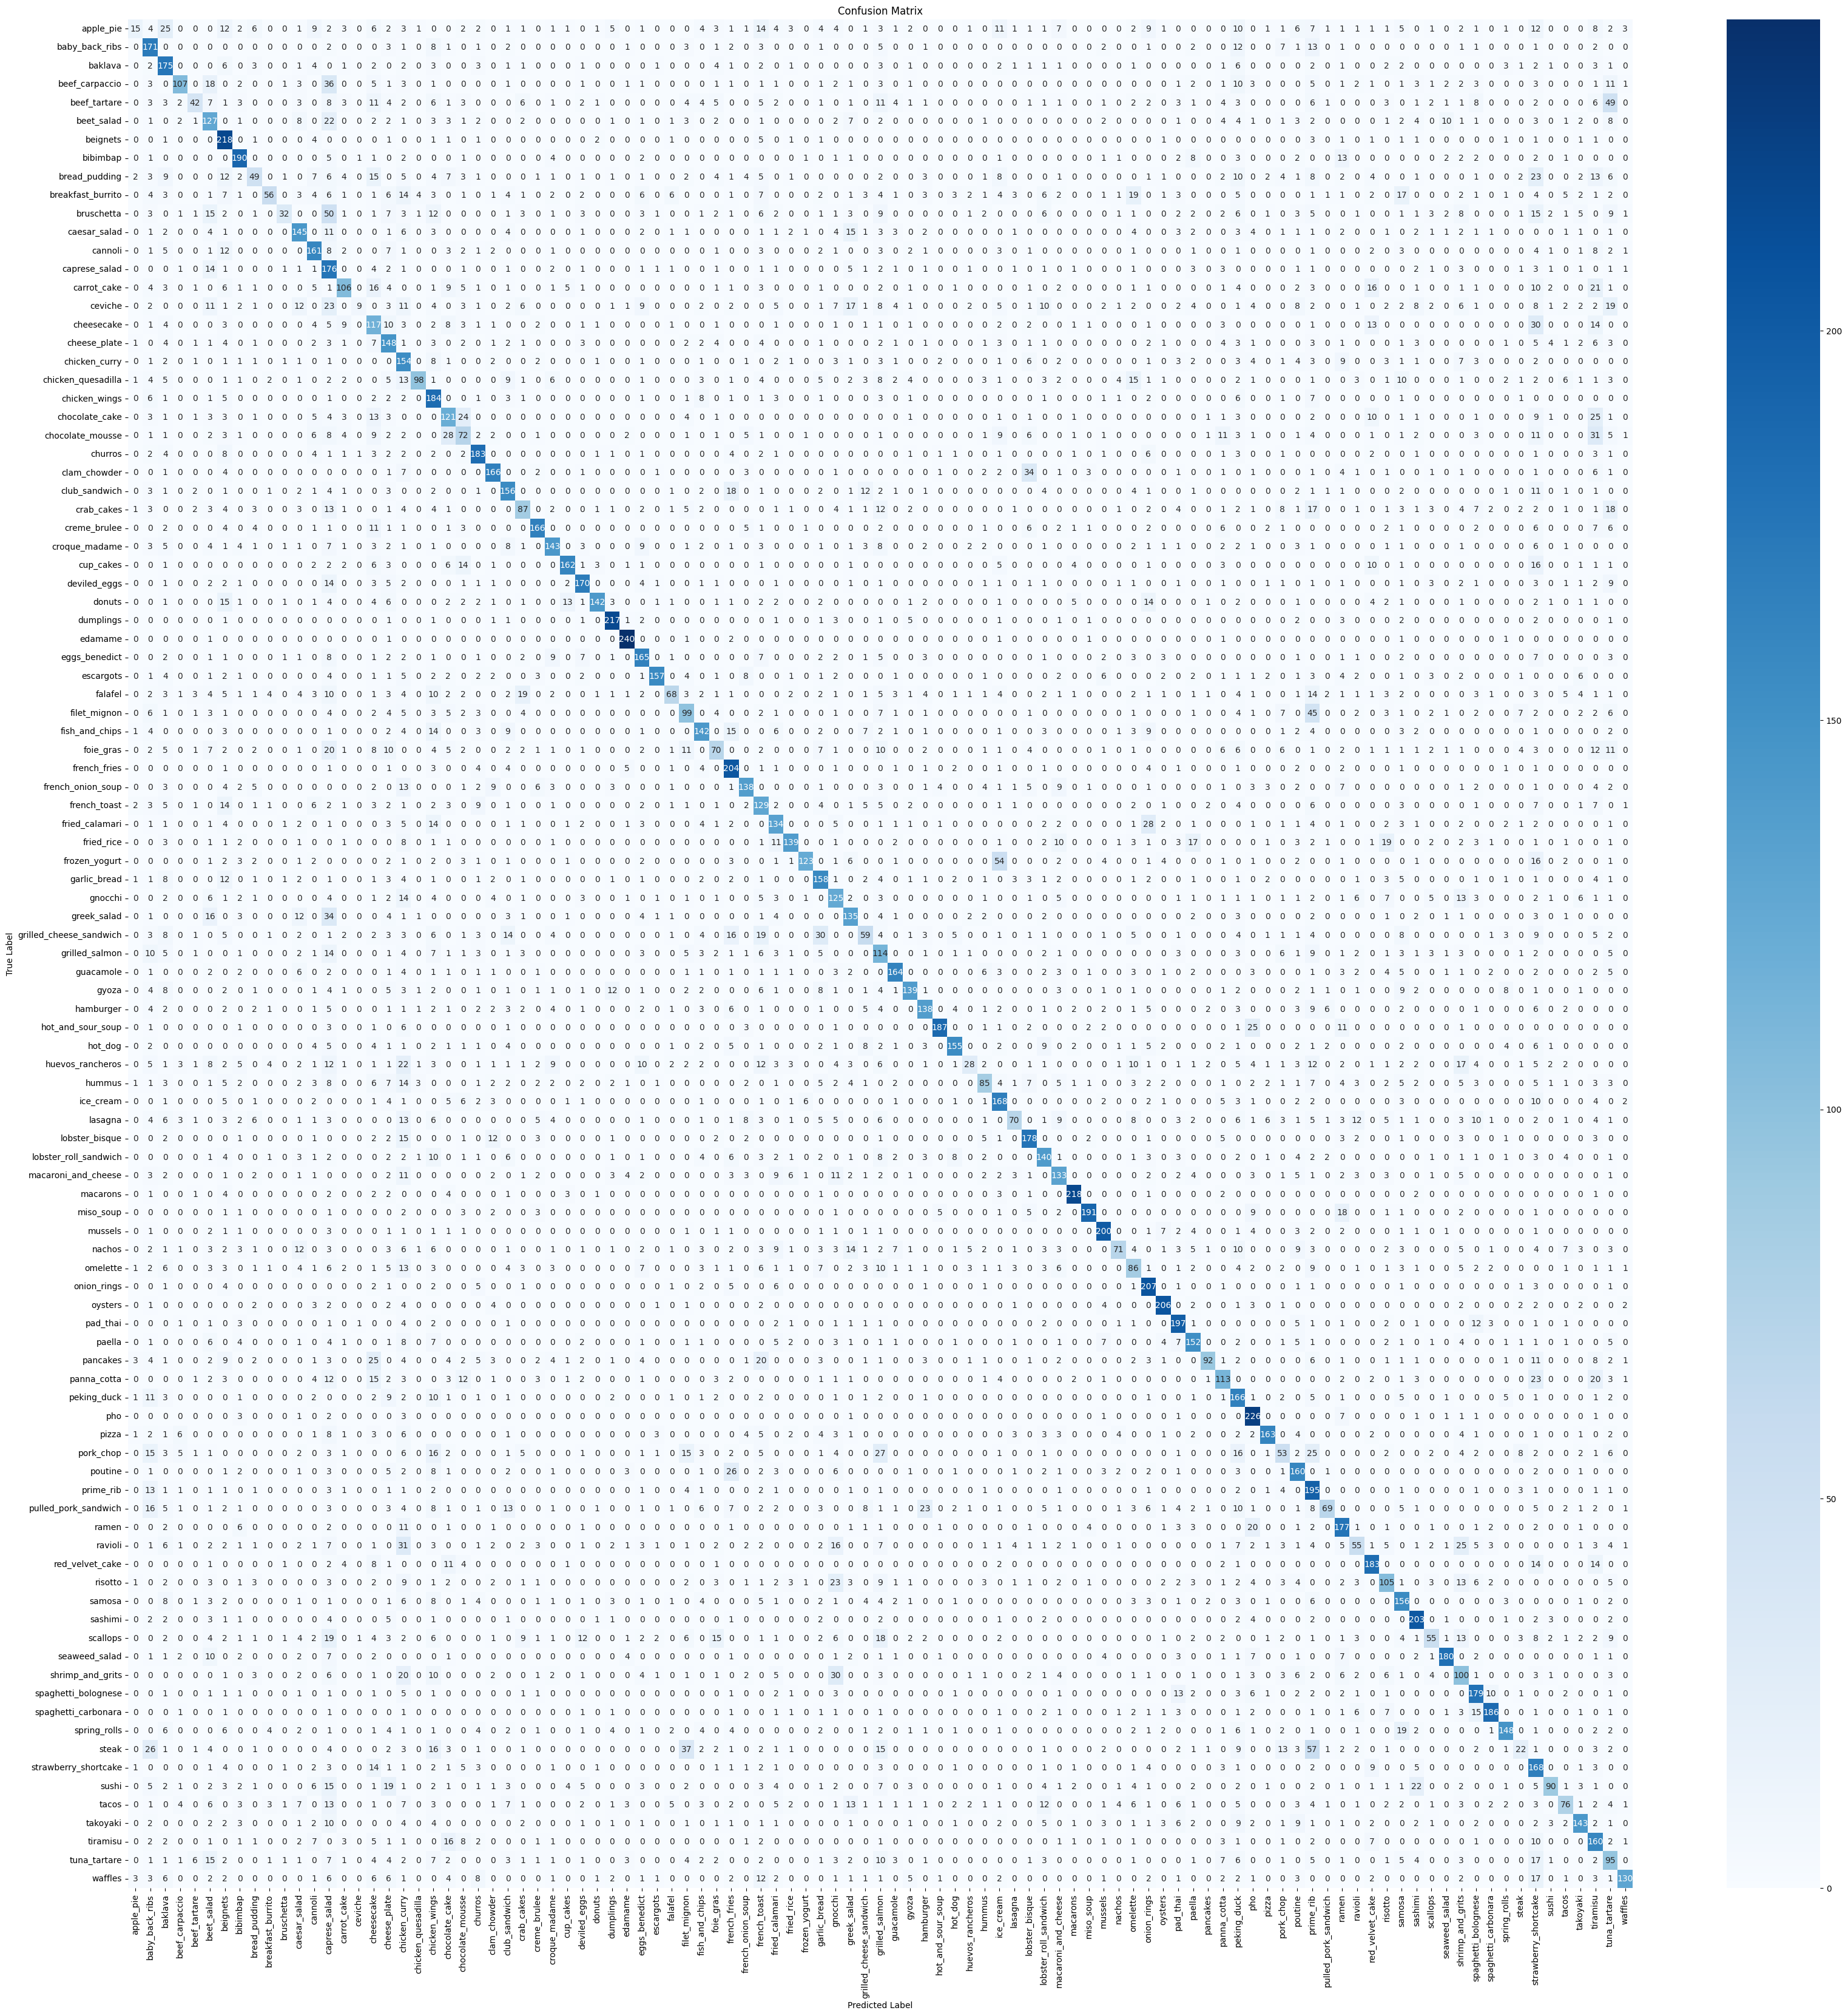

In [12]:
def calculate_metrics(model, test_data, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(40, 40))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, vmin=0, vmax=np.max(cm))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

calculate_metrics(model, test_data, class_names)

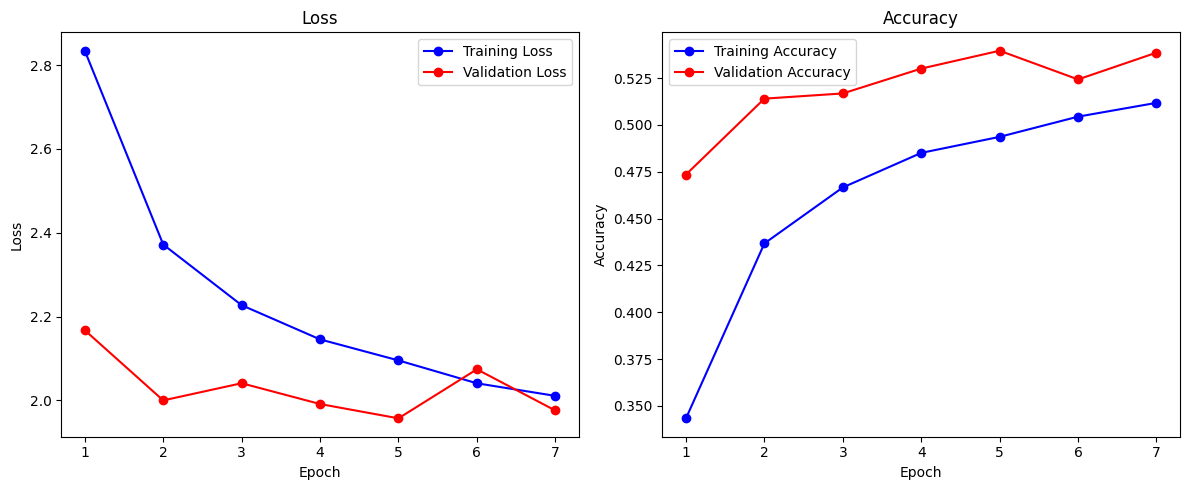

In [13]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_feature_extraction)

In [14]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

print(f"Total layers in the base model: {len(base_model.layers)}")

trainable_layers = len([layer for layer in base_model.layers if layer.trainable])
non_trainable_layers = len([layer for layer in base_model.layers if not layer.trainable])

print(f"Number of trainable layers: {trainable_layers}")
print(f"Number of non-trainable layers: {non_trainable_layers}")

model.summary()

Total layers in the base model: 175
Number of trainable layers: 75
Number of non-trainable layers: 100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               206949    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 23,794,661

In [15]:
history_fine_tuning = model.fit(train_data,
                                epochs=20,
                                validation_data=test_data,
                                callbacks=[model_checkpoint, early_stopping])

Epoch 1/20
2368/2368 [==============================] - 355s 145ms/step - loss: 1.4976 - accuracy: 0.6141 - val_loss: 1.4108 - val_accuracy: 0.6305
Epoch 2/20
2368/2368 [==============================] - 343s 145ms/step - loss: 1.3053 - accuracy: 0.6600 - val_loss: 1.3067 - val_accuracy: 0.6565
Epoch 3/20
2368/2368 [==============================] - 344s 145ms/step - loss: 1.1899 - accuracy: 0.6860 - val_loss: 1.2512 - val_accuracy: 0.6682
Epoch 4/20
2368/2368 [==============================] - 346s 146ms/step - loss: 1.0868 - accuracy: 0.7119 - val_loss: 1.2540 - val_accuracy: 0.6701
Epoch 5/20
2368/2368 [==============================] - 345s 146ms/step - loss: 1.0023 - accuracy: 0.7311 - val_loss: 1.2334 - val_accuracy: 0.6814
Epoch 6/20
2368/2368 [==============================] - 345s 145ms/step - loss: 0.9212 - accuracy: 0.7489 - val_loss: 1.2746 - val_accuracy: 0.6772
Epoch 7/20
2368/2368 [==============================] - 345s 145ms/step - loss: 0.8460 - accuracy: 0.7682 - val_

In [16]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 48s 60ms/step - loss: 1.2334 - accuracy: 0.6814


[1.2334461212158203, 0.6813861131668091]

Precision: 0.7006
Recall: 0.6814
F1-Score: 0.6825


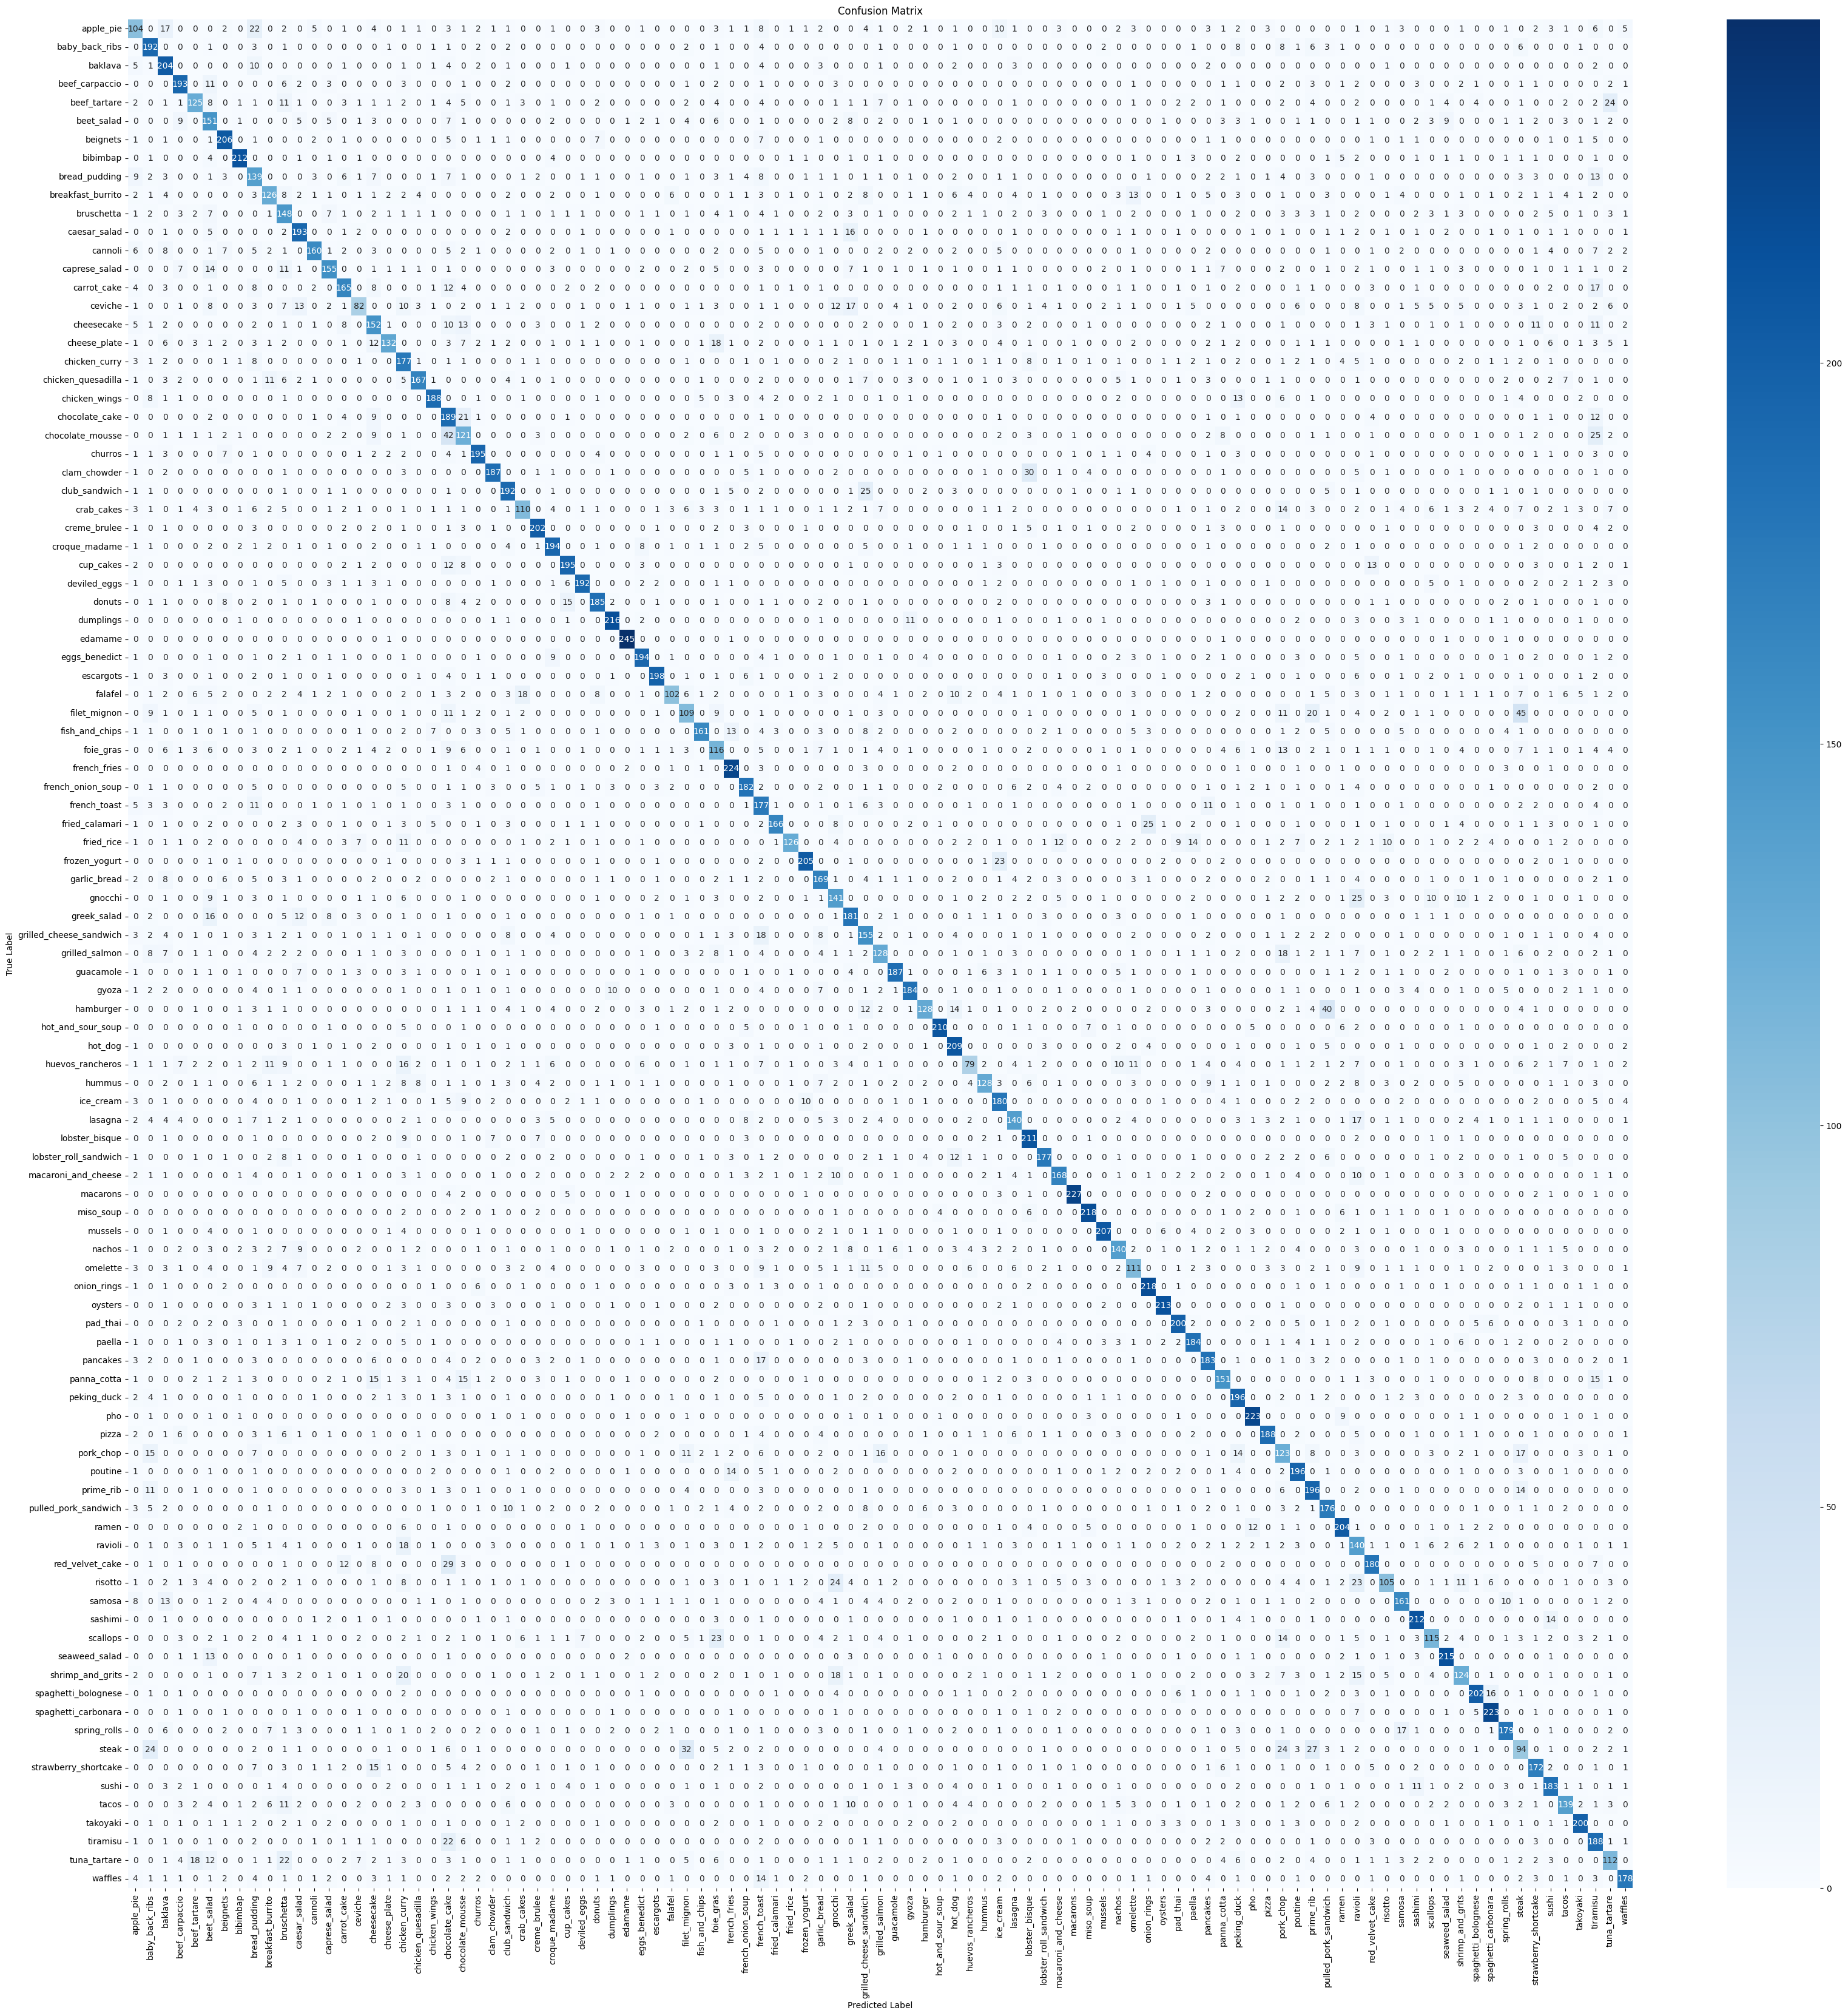

In [17]:
def calculate_metrics(model, test_data, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(preds, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(40, 40))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, vmin=0, vmax=np.max(cm))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

calculate_metrics(model, test_data, class_names)

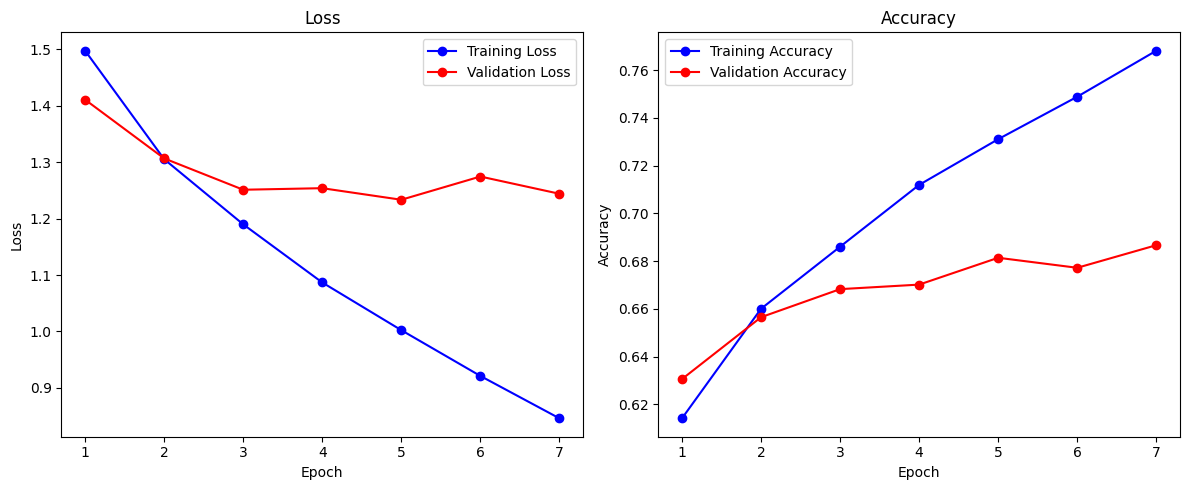

In [18]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()


plot_learning_curves(history_fine_tuning)
